In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Bootstrapping para intervalos de confianza y contraste de hipótesis con Python

> Bootstrapping como método no paramétrico para comparar estadísticos y crear intervalos de confianza con Python.


## Introducción

Los métodos estadísticos basados en muestreo repetido **(resampling)** se engloban dentro de la _estadística no paramétrica_, ya que no requieren de ninguna asunción sobre la distribución de las poblaciones estudiadas. Son, por lo tanto, una alternativa a los test paramétricos _(t-test, anova,…)_ cuando no se satisfacen sus condiciones o cuando se quiere hacer inferencia sobre un parámetro distinto a la media. A lo largo de este documento, se describe y aplica uno de los métodos de _resampling_ más utilizados: el _bootstrapping_.

Desde el punto de vista teórico, el escenario ideal para realizar inferencia sobre una población es disponer de infinitas (o una gran cantidad) de muestras de dicha población. Si para cada muestra se calcula el estadístico de interés, por ejemplo, la media, se obtiene lo que se conoce como distribución muestral. Esta distribución tiene dos características: su promedio tiende a converger con el valor real del parámetro poblacional, y su dispersión permite conocer el error esperado al estimar el estadístico con una muestra de un tamaño determinado.

En la práctica, no suele ser posible acceder a múltiples muestras. Si solo se dispone de una muestra, y esta es representativa de la población, cabe esperar que los valores en la muestra aparezcan aproximadamente con la misma frecuencia que en la población. El método de **bootstrapping (Bradley Efron, 1979))** se basa en generar nuevas pseudo-muestras, del mismo tamaño que la muestra original, mediante muestreo repetido _(sampling with replacement)_ de los datos disponibles.

Si la muestra original es representativa de la población, la distribución del estadístico calculada a partir de las pseudo-muestras (bootstrapping distribution) se aproxima a la distribución muestral que se obtendría si se pudiera acceder a la población para generar nuevas muestras.

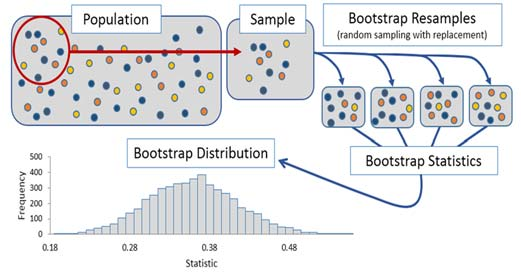

> Diagrama proceso de bootstrapping. Fuente: Frost, Oliver. (2018). Eine Webanwendung zur Planung und Auswertung von A/B-Tests auf Basis des Chi-Quadrat-Unabhängigkeitstests.


Así pues, bootstrapping es un proceso de simulación gracias al cual se puede aproximar la distribución muestral de un estadístico empleando únicamente una muestra inicial. Ahora bien, es importante destacar que información puede y no puede extraerse.

- Bootstrapping no proporciona una mejor estimación del estadístico que la obtenida con la muestra original.

- Bootstrapping simula el proceso de muestreo y con ello la variabilidad generada por este proceso. Gracias a esto, permite estimar la incertidumbre que se puede esperar de un estadístico calculado a partir de una muestra.


La estrategia de bootstrapping se puede emplear para resolver varios problemas:

- Calcular intervalos de confianza de un parámetro poblacional.

- Calcular la significancia estadística (p-value) de la diferencia entre poblaciones.

- Calcular intervalos de confianza para la diferencia entre poblaciones.

En cada uno, la hipótesis nula es distinta y, por lo tanto, la simulación de muestreo que tiene que realizarse. Esto significa que, aunque similares, el algoritmo debe adaptarse a cada caso de uso. En los siguientes apartados se muestran ejemplos de distintas aplicaciones.


## Intervalos de confianza de un parámetro poblacional

Supóngase que se dispone de un conjunto de ${n}$ observaciones ${X=\{x_1, x_2, ..., x_n\}}$ extraídas de una distribución (población). La media de la muestra ${\hat{X}}$ es la mejor aproximación para estimar la media poblacional ${\mu}$, ahora bien, ¿qué incertidumbre se tiene respecto a esta estimación? Es decir, ¿cuánto cabe esperar que el valor de ${\hat{X}}$ se desvíe de ${\mu}$ ?

Esta pregunta puede contestarse calculando intervalos de confianza (aproximación frecuentista) o con intervalos de credibilidad (aproximación bayesiana).

Existen varios métodos para estimar intervalos de confianza mediante el uso de _bootstrapping_:

- Intervalos basados en distribución normal (normal bootstrap intervals)

- Intervalos basados en percentiles (percentile bootstrap intervals)

- Intervalos basados en distribución Student's (bootstrap Student's t intervals)

- Bias-Corrected and Accelerated Bootstrap Method (BCA)

- Intervalos empíricos (empirical bootstrap intervals)

En este documento se describe cómo calcular intervalos basados en percentiles e intervalos empíricos. Si bien, estas dos aproximaciones son más intuitivas, la comunidad estadística parece coincidir en que lo más adecuado es utilizar Bias-Corrected and Accelerated Bootstrap Method (BCA). Puede encontrarse una implementación detallada de esta aproximación en 2019 Justin Bois and BE/Bi 103 a course staff.

> Nota: Esto también aplica a cualquier otro estadístico (mediana, media truncada...), no solo a la media.


## Intervalos basados en percentiles

Los intervalos basados en percentiles se basan en la idea de que, la distribución simulada, se asemeja a la distribución muestral del estadístico, y de que su desviación estándar se aproxima al error estándar de dicha distribución. Acorde a esto, se puede estimar el intervalo de confianza del estadístico utilizando los percentiles de la distribución obtenida.

Los pasos a seguir son:

1. Generar ${B}$ nuevas muestras mediante _bootstrapping_.

2. Calcular el estadístico de interés en cada nueva muestra.
3. Calcular los cuantiles inferior y superior acorde al intervalo deseado.
4. Generar el intervalo de confianza como [cuantil inferior, cuantil superior].

Por ejemplo, el intervalo de confianza del 95% obtenido a partir de 1000 muestras de bootstrapping, es el intervalo entre el el cuantil 0.025 y el cuantil 0.975 de la distribución obtenida.


## Ejemplo

Se dispone de una muestra formada por 30 observaciones de una variable aleatoria continua. Se desea calcular un intervalo de confianza del 95% para la media empleando el método de bootstrapping basado en percentiles.


## Librerías


In [4]:
# Tratamiento de datos
import pandas as pd
import numpy as np
from scipy.stats import trim_mean

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Ignorar warnings
import warnings

warnings.filterwarnings("ignore")

# Configuracion de matplotlib
plt.style.use("ggplot")
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 9)
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Varios
from tqdm import tqdm

## Datos

Los datos utilizados en este ejemplo se han obtenido del libro Comparing Groups Randomization and Bootstrap Methods Using R


In [5]:
# Datos
# ==============================================================================
datos = np.array(
    [
        81.372918,
        25.700971,
        4.942646,
        43.020853,
        81.690589,
        51.195236,
        55.659909,
        15.153155,
        38.745780,
        12.610385,
        22.415094,
        18.355721,
        38.081501,
        48.171135,
        18.462725,
        44.642251,
        25.391082,
        20.410874,
        15.778187,
        19.351485,
        20.189991,
        27.795406,
        25.268600,
        20.177459,
        15.196887,
        26.206537,
        19.190966,
        35.481161,
        28.094252,
        30.305922,
    ]
)

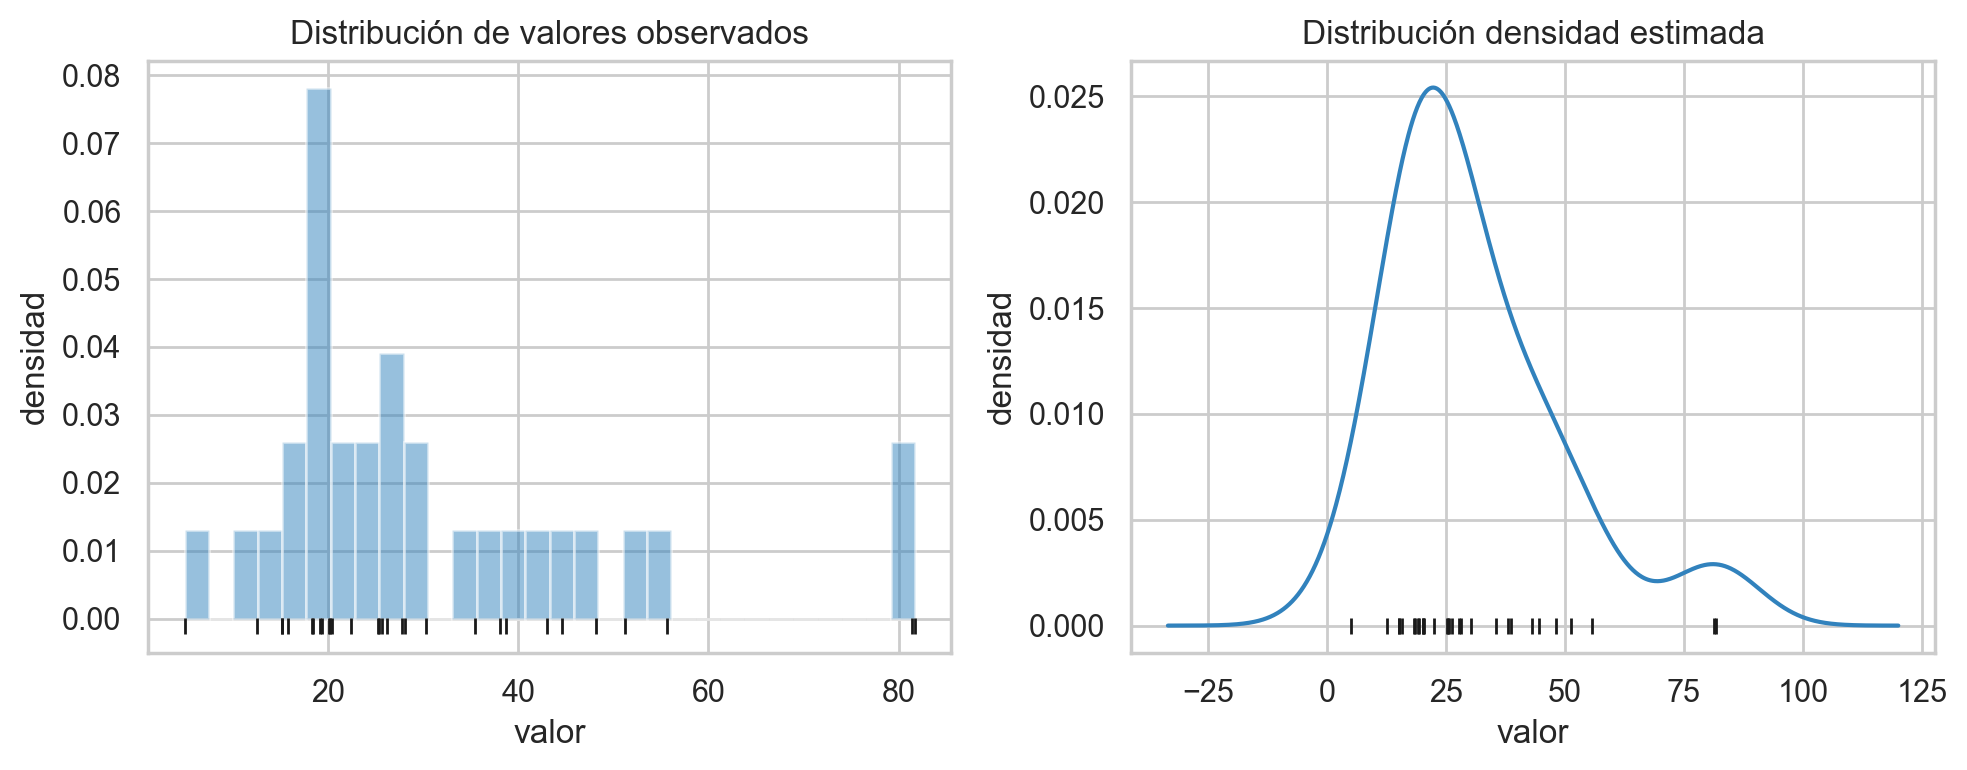

In [7]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5, label="muestra_1")
axs[0].plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
axs[0].set_title("Distribución de valores observados")
axs[0].set_xlabel("valor")
axs[0].set_ylabel("densidad")

pd.Series(datos).plot.kde(ax=axs[1], color="#3182bd")
axs[1].plot(datos, np.full_like(datos, 0), "|k", markeredgewidth=1)
axs[1].set_title("Distribución densidad estimada")
axs[1].set_xlabel("valor")
axs[1].set_ylabel("densidad")

fig.tight_layout()
plt.show()

La representación gráfica muestra evidencias de que los datos no se distribuyen de forma normal. Esto implica que, la aproximación basada en el teorema del límite central para estimar el error estándar ${SE = \frac{sd}{\sqrt{n}}}$, deja de ser buena y con ella los intervalos paramétricos basados en la estructura ${[\text{parámetro estimado} \pm t_{\alpha}SE]}$.
Una alternativa para poder calcular intervalos de confianza es emplear _bootstrapping_.


## Intervalo de confianza basado en percentiles

Mediante bootstrapping, se simula la variabilidad esperada en el estadístico, en este caso la media, debido únicamente al muestreo aleatorio.


In [8]:
def calcular_estadistico(x):
    """
    Función para calcular el estadístico de interés.

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    Returns
    -------
    estadístico: float
        valor del estadístico.
    """
    estadistico = np.mean(x)

    return estadistico

In [9]:
def bootstraping(x, fun_estadistico, n_iteraciones=9999):
    """
    Función para calcular el valor del estadístico en múltiples muestras generadas
    mediante muestreo repetido con reposición (bootstrapping).

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.

    n_iteraciones : int
        número iteraciones (default `9999`).

    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada muestra de bootstrapping.
    """

    n = len(x)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)

    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample)

    return dist_boot

In [10]:
dist_boot = bootstraping(
    x=datos, fun_estadistico=calcular_estadistico, n_iteraciones=9999
)

100%|██████████| 9999/9999 [00:00<00:00, 57863.04it/s]


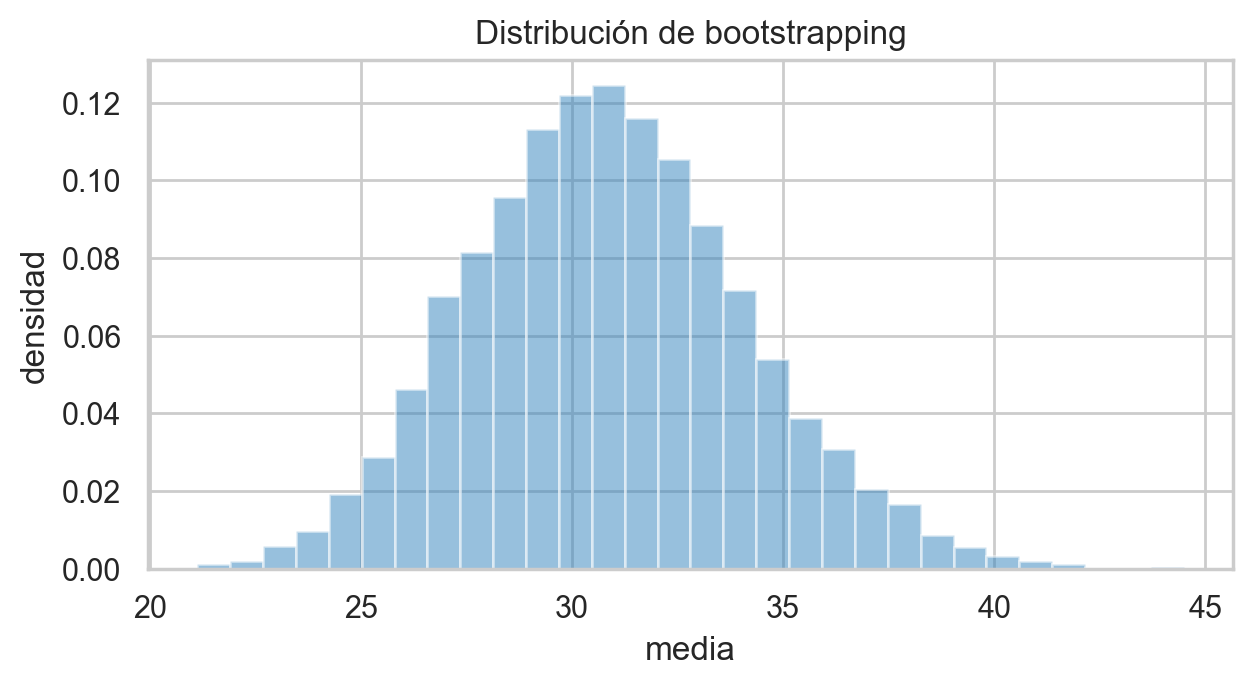

In [11]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 3.3))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.set_title("Distribución de bootstrapping")
ax.set_xlabel("media")
ax.set_ylabel("densidad")
plt.show()

La dispersión de la distribución obtenida por bootstrapping es una aproximación del error estándar esperado debido a proceso de muestreo. Por esta razón, pueden emplearse sus percentiles para calcular intervalos de confianza.


In [12]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a=dist_boot, q=[0.025, 0.975])
print("-------------------------------")
print("Intervalo basado en percentiles")
print("-------------------------------")
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[24.7909045  37.75493123]


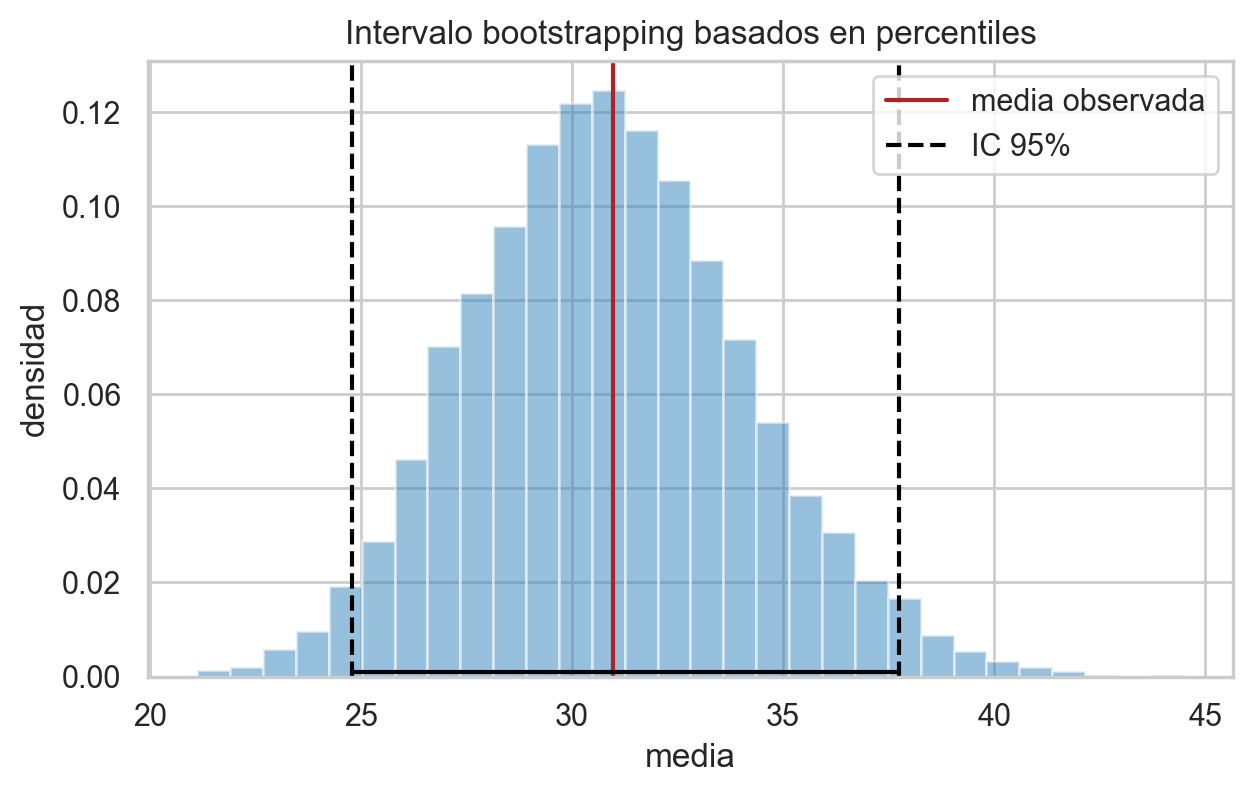

In [13]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.axvline(x=datos.mean(), color="firebrick", label="media observada")
ax.axvline(x=cuantiles[0], color="black", linestyle="--", label="IC 95%")
ax.axvline(x=cuantiles[1], color="black", linestyle="--")
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color="black")
ax.set_title("Intervalo bootstrapping basados en percentiles")
ax.set_xlabel("media")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

## Intervalos empíricos

La aproximación basada en percentiles estima la diferencia esperada entre la media muestral ${\hat{X}}$ y la media poblacional ${\mu}$ a partir de la dispersión de la distribución obtenida mediante bootstrapping. En lugar de esto, la aproximación empírica trata de estimar directamente la diferencia esperada entre la media muestral ${\hat{X}}$ y la media poblacional μ
a partir de las diferencias entre la media muestral ${\hat{X}}$ y y las medias de cada iteración de bootstrapping ${\hat{X}^{b_i}}$

Si se parte de los siguientes elementos:

- ${X}$: muestra formada por n observaciones

$${X=\{x_1, x_2, ..., x_n\}}$$

- ${\mu}$: media poblacional, cuyo valor se desconoce y sobre el que se quiere hacer la inferencia.

- ${\hat{X}}$: media muestral, media calculada con los valores observados.
- ${\hat{X}^{b}}$: media de una muestra generada por bootstrapping.
- ${V}$: diferencia esperada de ${\hat{X}}$ respecto de ${\mu}$ $${V=\hat{X} -\mu}$$
- ${\hat{V}^{b}}$: diferencia de ${\hat{X}^{b}}$ respecto de ${\hat{X}}$ $${\hat{V}^{b}=\hat{X}^{b} - \hat{X}}$$

Acorde a la ley de los grandes números, la distribución de ${\hat{X}}$ está centrada en ${\mu}$. De ahí que, la mejor estimación disponible de la media poblacional, sea la media muestral. Del mismo modo, la distribución de ${\hat{X}^{b}}$ obtenida por bootstraping a partir de ${X}$ está centrada en ${\hat{X}}$

Por otro lado, la distribución de ${V=\hat{X} -\mu}$ epresenta la variación de la media muestral respecto a la media poblacional. Esto es lo que interesa obtener para calcular el intervalo de confianza. Como ${\mu}$ se desconoce, no hay forma de calcular directamente la distribución de ${V}$. Sin embargo, se puede aproximar a partir de las diferencias entre las medias de las muestras de bootstrapping y la media muestral.

$${\hat{V}^{b}=\hat{X}^{b} - \hat{X}}$$

Una vez obtenida la distribución de ${\hat{V}^{b}}$ se puede obtener el intervalo de confianza para ${\mu}$:

$${\text{Intervalo de confianza del 95}}$$

$$[{ \hat{X} - \hat{V}^{b}_{0.975}, \hat{X} - \hat{V}^{b}_{0.025} }]$$

donde ${\hat{V}^{b}_{0.025}}$ y ${\hat{V}^{b}\_{0.975}}$ son los respectivos cuantiles de la distribución de ${\hat{V}^{b}}$ obtenida por bootstrapping.


### Algoritmo

Los pasos a seguir para calcular los intervalos mediante la aproximación empírica son:

1. Calcular la media de la muestra ${\hat{X}}$.
2. Obtener ${B}$ muestras de bootstrapping mediante muestreo repetido.
3. Para cada muestra de bootstrapping:
   1. Calcular la media ${\hat{X}^{b}}$
   2. Calcular la diferencia ${\hat{V}^{b}=\hat{X}^{b} - \hat{X}}$
4. Calcular los cuantiles correspondientes al intervalo de interés a partir de los valores ${\hat{V}^{b}}$
5. Calcular el intervalo de confianza como ${\hat{X}}$ - cuantiles.

Tanto en la aproximación por percentiles como en la empírica se utilizan cuantiles, sin embargo, existe una diferencia importante. En la primera, se calculan directamente sobre la distribución del estadístico, mientras que en la aproximación empírica, se calculan sobre la distribución de variación.
